# 0. Imports

In [2]:
# for data handling and manipulation:
import pandas as pd
import numpy as np

# for os handling
import os

# for pre-processing
from sklearn.preprocessing import StandardScaler

# import the classifiers to fit:
from sklearn.naive_bayes import GaussianNB 

# import metrics
from sklearn.metrics import fbeta_score, classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay, make_scorer

# for tabulating results
from tabulate import tabulate

# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# for handling warnings
import warnings

# for hyper-parameter tuning
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.model_selection import GridSearchCV

In [3]:
# Reading the train, test and validation data into this notebook 

X_train_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_train_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_train_gray = X_train_gray.to_numpy()

y_train = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_train.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_train = y_train.to_numpy(dtype = 'int64').flatten()

X_val_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_val_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_val_gray = X_val_gray.to_numpy()

y_val = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_val.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_val = y_val.to_numpy(dtype = 'int64').flatten()

X_test_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_test_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_test_gray = X_test_gray.to_numpy()

y_test = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_test.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_test = y_test.to_numpy(dtype = 'int64').flatten()

In [4]:
X_train_gray.shape, y_train.shape, X_val_gray.shape, y_val.shape, X_test_gray.shape, y_test.shape

((791, 98), (791,), (98, 98), (98,), (100, 98), (100,))

In [5]:
X_final_train_gray = np.concatenate((X_train_gray, X_val_gray), axis = 0)
y_train_final = np.concatenate((y_train, y_val), axis = 0)

## Function to calculate metrics

In [6]:
def calculate_metrics(y_pred, y_true, normalize = False):
    
    with warnings.catch_warnings():
        
        warnings.filterwarnings('ignore')
        # calculate accuracy:
        temp = round(accuracy_score(y_true, y_pred),2)
        print('Accuracy in detecting Accident class: {}'.format(temp))
        print('\n------------------------------------------------------------------------------------------\n')
        
        my_data = []
        cr = classification_report(y_true, y_pred, output_dict = True)

        # calculate precision:
        my_data.append(['Precision',round(cr['0']['precision'],2), round(cr['1']['precision'],2)])

        # calculate recall:
        my_data.append(['Recall',round(cr['0']['recall'],2), round(cr['1']['recall'],2)])

        # f1-score:
        my_data.append(['f1-score',round(cr['0']['f1-score'],2), round(cr['1']['f1-score'],2)])

        head = ['Metric','Non-Accident images','Accident images']

        print(tabulate(my_data, headers = head, tablefmt = 'grid'))
        print('\n------------------------------------------------------------------------------------------\n')

        # calculate sensitivity (recall of positive class for binary classification)
        temp = round(cr['1']['recall'],2)
        print('Sensitivity/ ability to correctly classifiy to Accident class is: {}'.format(temp))
    
        # calculate specificity (recall of negative class for binary classification)
        temp = round(cr['0']['recall'],2)
        print('Specificity/ ability to correctly classifiy to Non-Accident class is: {}'.format(temp))
        print('\n------------------------------------------------------------------------------------------\n')

        # calculate f1-beta score:
        print('Fbeta score with beta = 1.4 is: {}'.format(round(fbeta_score(y_true, y_pred,beta = 1.4),2)))
        print('\n------------------------------------------------------------------------------------------\n')

        # Confusion matrix:
        if normalize == False:
            cm = confusion_matrix(y_true, y_pred)
            disp = ConfusionMatrixDisplay(cm, display_labels = ["Non-Accident", 'Accident'])
            disp.plot()
            plt.title('Confusion Matrix')
            plt.show()
            print('\n------------------------------------------------------------------------------------------\n')
        else:
            cm = confusion_matrix(y_true, y_pred, normalize='all')
            disp = ConfusionMatrixDisplay(cm, display_labels = ["Non-Accident", 'Accident'])
            disp.plot()
            plt.title('Confusion Matrix')
            plt.show()
            print('\n------------------------------------------------------------------------------------------\n')

        # ROC curve:
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        plt.plot(fpr, tpr, marker = 'o')
        plt.xlabel('% of Non-Accidents incorrectly classified')
        plt.ylabel('% of Accidents correctly classified')
        plt.title('ROC Curve')
        plt.show()
        print('\n------------------------------------------------------------------------------------------\n')
        temp = round(auc(fpr, tpr),2)
        print('AUC score is: {}'.format(temp))

    return 

# Fitting a Naive Bayes Classifier

## On grayscale images

## Scale the data

In [7]:
scaler = StandardScaler()
X_train_gray_sc = scaler.fit_transform(X_final_train_gray)
X_test_gray_sc = scaler.transform(X_test_gray)

In [8]:
X_train_gray_sc.shape, X_test_gray_sc.shape

((889, 98), (100, 98))

### Let's formally do hyper-parameter tuning, using Bayes Optimization and Grid Search. The default parameters are also an option to use for both Bayes and Grid search CV, if they indeed have the best generalizing capability, then it will get detected.

In [9]:
parameters = {'var_smoothing':Real(0,1,'uniform')}
fbeta_scorer = make_scorer(fbeta_score, beta = 1.4)                                                                     

In [14]:
opt = BayesSearchCV(GaussianNB(), parameters, n_iter = 200, scoring = fbeta_scorer, verbose = 5, random_state = 5000, cv = 3)

np.int = int  # numpy doesn't have int attribute now, to avoid an error in existing code, need to use int in place of this.

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    opt.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ..var_smoothing=0.8521957323049895;, score=0.225 total time=   0.0s
[CV 2/3] END ..var_smoothing=0.8521957323049895;, score=0.263 total time=   0.0s
[CV 3/3] END ..var_smoothing=0.8521957323049895;, score=0.192 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ..var_smoothing=0.6159027912677043;, score=0.252 total time=   0.0s
[CV 2/3] END ..var_smoothing=0.6159027912677043;, score=0.314 total time=   0.0s
[CV 3/3] END ..var_smoothing=0.6159027912677043;, score=0.280 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ..var_smoothing=0.9597329302645083;, score=0.189 total time=   0.0s
[CV 2/3] END ..var_smoothing=0.9597329302645083;, score=0.255 total time=   0.0s
[CV 3/3] END ..var_smoothing=0.9597329302645083;, score=0.173 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END .var_smoothing=0.01596

In [22]:
print('Best score on a fold of train data:', round(opt.best_score_,6))

Best score on a fold of train data: 0.427466


In [16]:
print('Best parameters:', opt.best_params_)

Best parameters: OrderedDict([('var_smoothing', 0.0)])


## Trying Grid Search CV now

In [17]:
parameters = {'var_smoothing':[0,1e-1,1e-3,1e-5,1e-7,1e-9,2e-1,2e-3,2e-5,2e-7,2e-9,3e-1,3e-3,3e-5,3e-7,3e-9,4e-1,4e-3,4e-5,4e-7,4e-9,
                               5e-1,5e-3,5e-5,5e-7,5e-9, 6e-1,6e-3,6e-5,6e-7,6e-9, 7e-1,7e-3,7e-5,7e-7,7e-9, 8e-1,8e-3,8e-5,8e-7,8e-9,
                               9e-1,9e-3,9e-5,9e-7,9e-9, 10e-1,10e-3,10e-5,10e-7,10e-9]} 
fbeta_scorer = make_scorer(fbeta_score, beta = 1.4)                                                                     

In [18]:
opt_gs = GridSearchCV(GaussianNB(), parameters, scoring = fbeta_scorer, verbose = 5, cv = 3)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    opt_gs.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 51 candidates, totalling 153 fits
[CV 1/3] END ...................var_smoothing=0;, score=0.380 total time=   0.0s
[CV 2/3] END ...................var_smoothing=0;, score=0.480 total time=   0.0s
[CV 3/3] END ...................var_smoothing=0;, score=0.422 total time=   0.0s
[CV 1/3] END .................var_smoothing=0.1;, score=0.351 total time=   0.0s
[CV 2/3] END .................var_smoothing=0.1;, score=0.444 total time=   0.0s
[CV 3/3] END .................var_smoothing=0.1;, score=0.363 total time=   0.0s
[CV 1/3] END ...............var_smoothing=0.001;, score=0.380 total time=   0.0s
[CV 2/3] END ...............var_smoothing=0.001;, score=0.480 total time=   0.0s
[CV 3/3] END ...............var_smoothing=0.001;, score=0.422 total time=   0.0s
[CV 1/3] END ...............var_smoothing=1e-05;, score=0.380 total time=   0.0s
[CV 2/3] END ...............var_smoothing=1e-05;, score=0.480 total time=   0.0s
[CV 3/3] END ...............var_smoothing=1e-05

In [21]:
print('Best score on a fold of train data:', round(opt_gs.best_score_,6))

Best score on a fold of train data: 0.427466


In [20]:
print('Best parameters:', opt_gs.best_params_)

Best parameters: {'var_smoothing': 0}


### Both Bayes Search and Grid Search give same best scores upto 6 decimal places.  

In [25]:
clf = GaussianNB( **opt_gs.best_params_)
clf


GaussianNB(var_smoothing=0)

Accuracy in detecting Accident class: 0.56

------------------------------------------------------------------------------------------

+-----------+-----------------------+-------------------+
| Metric    |   Non-Accident images |   Accident images |
+===========+=======================+===================+
| Precision |                  0.56 |              0.55 |
+-----------+-----------------------+-------------------+
| Recall    |                  0.75 |              0.34 |
+-----------+-----------------------+-------------------+
| f1-score  |                  0.65 |              0.42 |
+-----------+-----------------------+-------------------+

------------------------------------------------------------------------------------------

Sensitivity/ ability to correctly classifiy to Accident class is: 0.34
Specificity/ ability to correctly classifiy to Non-Accident class is: 0.75

------------------------------------------------------------------------------------------

Fbeta scor

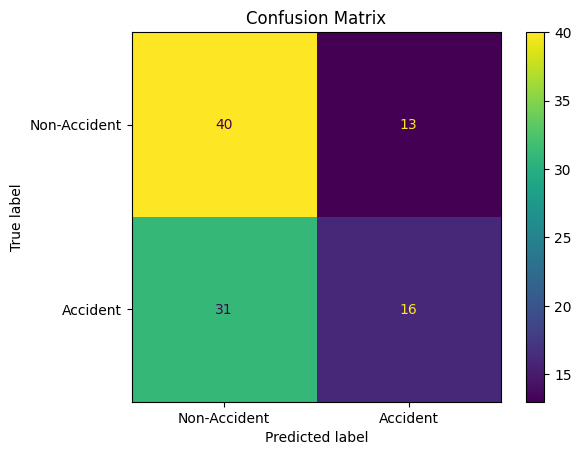


------------------------------------------------------------------------------------------



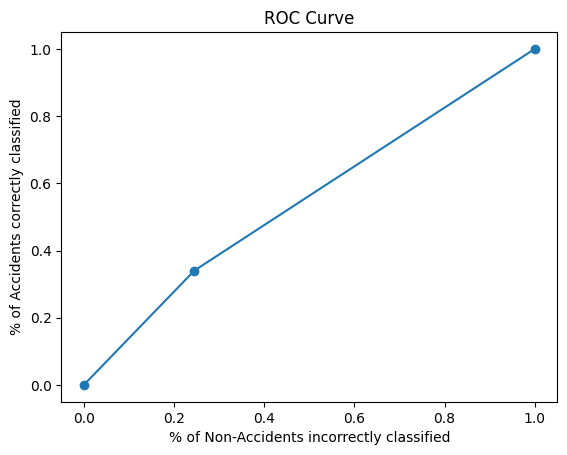


------------------------------------------------------------------------------------------

AUC score is: 0.55


In [26]:
clf.fit(X_train_gray_sc, y_train_final)
pred_gray_val = clf.predict(X_test_gray_sc)
calculate_metrics(pred_gray_val, y_test)

So, the best we could do using **Naive Bayes** is a test fbeta score (beta = 1.4) of 0.39, with the parameters:
- var_smoothing: 0.0